# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_20', 'ORACLE.run2_32', 'ORACLE.run2_44', 'ORACLE.run2_38', 'ORACLE.run2_50', 'ORACLE.run2_26', 'ORACLE.run2_8', 'ORACLE.run2_14'}


{'ORACLE.run1_38', 'ORACLE.run1_32', 'ORACLE.run1_20', 'ORACLE.run1_14', 'ORACLE.run1_44', 'ORACLE.run1_50', 'ORACLE.run1_8', 'ORACLE.run1_26'}


tensor([[[-0.6014,  0.2907,  0.4912,  ..., -1.4034, -2.0549, -0.6115],
         [-0.4711,  0.1002, -0.4711,  ..., -0.3208,  0.2005,  0.8420]],

        [[ 0.9001, -0.2436,  0.6989,  ..., -0.6672,  1.0802,  0.0212],
         [-1.4084, -0.6460, -0.2012,  ..., -0.7625, -0.0847,  0.2436]],

        [[ 0.1969, -0.4976,  0.7152,  ...,  0.1037,  0.1348, -0.8189],
         [ 1.3164, -0.4043,  0.7463,  ...,  0.6634, -0.1037,  0.3939]],

        ...,

        [[-0.3715, -0.5175, -0.9421,  ..., -0.3384, -0.2057,  1.1212],
         [-0.1460, -0.9819,  0.4511,  ..., -0.3516, -1.0084, -0.1261]],

        [[-0.4882,  0.4236,  0.7897,  ...,  1.0123, -0.2082, -1.6799],
         [-0.1077,  0.5313, -0.3446,  ...,  0.0359,  0.3446, -0.7036]],

        [[-1.0646, -0.0139, -0.8976,  ..., -0.6262, -0.4871, -1.2316],
         [-1.0715, -0.3757, -1.1689,  ...,  0.0557,  0.4940,  0.0139]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.6801, train_label_loss: 2.7852, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3200.6217, train_label_loss: 1.1602, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3204.5563, train_label_loss: 1.8926, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3210.8851, train_label_loss: 0.7840, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3200.6462, train_label_loss: 0.8636, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3213.9602, train_label_loss: 1.2018, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3222.3792, train_label_loss: 0.6397, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3208.1925, train_label_loss: 0.5620, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3218.7071, train_label_loss: 0.6134, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3238.5863, train_label_loss: 1.2393, 


epoch: 1, source_val_acc_label: 0.6353, target_val_acc_label: 0.6449, source_val_label_loss: 0.9834, target_val_label_loss: 0.9520, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9687, train_label_loss: 0.8622, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3252.7909, train_label_loss: 0.6051, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3249.0752, train_label_loss: 1.3875, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3263.7534, train_label_loss: 1.1262, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3260.4280, train_label_loss: 0.5465, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3265.3224, train_label_loss: 1.1464, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3267.9135, train_label_loss: 1.2267, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3251.0148, train_label_loss: 0.4418, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3263.6625, train_label_loss: 1.0115, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3276.4489, train_label_loss: 1.0598, 


epoch: 2, source_val_acc_label: 0.6554, target_val_acc_label: 0.6690, source_val_label_loss: 0.9283, target_val_label_loss: 0.8847, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9687, train_label_loss: 0.5056, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3254.0408, train_label_loss: 0.6908, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3267.7228, train_label_loss: 1.2061, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3254.6173, train_label_loss: 0.8910, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3245.1331, train_label_loss: 0.4523, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3265.3271, train_label_loss: 1.2357, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3241.0599, train_label_loss: 1.1999, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3251.7893, train_label_loss: 0.9418, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3262.7400, train_label_loss: 1.1962, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3265.1176, train_label_loss: 0.4588, 


epoch: 3, source_val_acc_label: 0.6783, target_val_acc_label: 0.6906, source_val_label_loss: 0.8749, target_val_label_loss: 0.8276, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9747, train_label_loss: 0.8449, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3241.9286, train_label_loss: 0.7001, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3261.8567, train_label_loss: 1.5097, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3261.5024, train_label_loss: 0.7697, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3248.9283, train_label_loss: 0.6844, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3266.7145, train_label_loss: 0.7888, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3270.5484, train_label_loss: 0.4649, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3263.8115, train_label_loss: 0.4410, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3263.8368, train_label_loss: 0.9849, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3272.8244, train_label_loss: 0.8113, 


epoch: 4, source_val_acc_label: 0.7049, target_val_acc_label: 0.7130, source_val_label_loss: 0.8241, target_val_label_loss: 0.7805, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9740, train_label_loss: 1.2311, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3249.7175, train_label_loss: 1.1239, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3249.5610, train_label_loss: 0.5057, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3264.6527, train_label_loss: 0.7016, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3255.5980, train_label_loss: 0.7841, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3268.6537, train_label_loss: 0.4650, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3267.0727, train_label_loss: 0.7688, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3257.6242, train_label_loss: 0.8384, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3257.7058, train_label_loss: 0.3792, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3266.7136, train_label_loss: 0.9892, 


epoch: 5, source_val_acc_label: 0.7160, target_val_acc_label: 0.7210, source_val_label_loss: 0.7975, target_val_label_loss: 0.7653, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9736, train_label_loss: 0.3314, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3246.4146, train_label_loss: 0.9600, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3264.4023, train_label_loss: 0.3876, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3259.0501, train_label_loss: 0.1969, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3252.1509, train_label_loss: 0.5740, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3262.7516, train_label_loss: 0.7366, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3260.1969, train_label_loss: 0.8599, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3258.9276, train_label_loss: 0.3581, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3267.8241, train_label_loss: 0.6899, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3269.6030, train_label_loss: 0.4811, 


epoch: 6, source_val_acc_label: 0.7231, target_val_acc_label: 0.7254, source_val_label_loss: 0.7837, target_val_label_loss: 0.7594, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9690, train_label_loss: 0.2262, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3250.6420, train_label_loss: 0.6637, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3259.4550, train_label_loss: 0.5225, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3261.0364, train_label_loss: 1.1350, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3257.9506, train_label_loss: 0.2828, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3267.3782, train_label_loss: 0.3110, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3264.6216, train_label_loss: 0.7929, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3247.4683, train_label_loss: 0.3277, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3256.1805, train_label_loss: 0.3612, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3261.9670, train_label_loss: 0.5217, 


epoch: 7, source_val_acc_label: 0.7210, target_val_acc_label: 0.7240, source_val_label_loss: 0.7747, target_val_label_loss: 0.7529, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9692, train_label_loss: 0.2972, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3246.2214, train_label_loss: 0.3525, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3258.8829, train_label_loss: 0.8317, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3266.8423, train_label_loss: 0.7288, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3247.3427, train_label_loss: 0.6592, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3264.8719, train_label_loss: 0.1807, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3263.1449, train_label_loss: 0.3882, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3256.6365, train_label_loss: 0.6270, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3260.2300, train_label_loss: 0.3898, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3264.9651, train_label_loss: 0.4175, 


epoch: 8, source_val_acc_label: 0.7254, target_val_acc_label: 0.7264, source_val_label_loss: 0.7848, target_val_label_loss: 0.7718, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9715, train_label_loss: 0.7238, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3256.6024, train_label_loss: 0.4296, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3250.0312, train_label_loss: 0.4400, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3263.7843, train_label_loss: 0.3722, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3256.5314, train_label_loss: 0.4322, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3270.0833, train_label_loss: 0.8871, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3256.8864, train_label_loss: 0.4950, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3250.3016, train_label_loss: 0.5272, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3266.6128, train_label_loss: 0.4100, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3269.2186, train_label_loss: 0.2521, 


epoch: 9, source_val_acc_label: 0.7279, target_val_acc_label: 0.7284, source_val_label_loss: 0.7967, target_val_label_loss: 0.7841, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9752, train_label_loss: 0.1767, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3255.1875, train_label_loss: 0.3642, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3260.6558, train_label_loss: 0.2422, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3267.9165, train_label_loss: 0.7088, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3251.0037, train_label_loss: 0.2941, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3266.4805, train_label_loss: 0.2445, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3267.4206, train_label_loss: 0.6054, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3257.7433, train_label_loss: 0.2225, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3268.2774, train_label_loss: 0.6192, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3263.1215, train_label_loss: 0.3714, 


epoch: 10, source_val_acc_label: 0.7245, target_val_acc_label: 0.7250, source_val_label_loss: 0.8088, target_val_label_loss: 0.7998, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9717, train_label_loss: 0.5523, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3256.4291, train_label_loss: 0.2452, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3259.9114, train_label_loss: 0.4143, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3252.2145, train_label_loss: 0.3200, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3244.5010, train_label_loss: 0.2490, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3257.6324, train_label_loss: 0.5358, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3268.8602, train_label_loss: 0.4394, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3247.5449, train_label_loss: 0.4639, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3266.6251, train_label_loss: 0.5709, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3266.6582, train_label_loss: 0.6755, 


epoch: 11, source_val_acc_label: 0.7243, target_val_acc_label: 0.7248, source_val_label_loss: 0.8297, target_val_label_loss: 0.8204, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.9719, train_label_loss: 0.2833, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3245.0093, train_label_loss: 0.3079, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3264.1210, train_label_loss: 0.1889, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3267.0888, train_label_loss: 0.4891, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3252.7089, train_label_loss: 0.5258, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3266.4460, train_label_loss: 0.0282, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3271.5830, train_label_loss: 0.4447, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3261.3809, train_label_loss: 0.4514, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3260.3920, train_label_loss: 0.4801, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3271.6691, train_label_loss: 0.5378, 


epoch: 12, source_val_acc_label: 0.7247, target_val_acc_label: 0.7228, source_val_label_loss: 0.8551, target_val_label_loss: 0.8501, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.9709, train_label_loss: 0.7827, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3259.9076, train_label_loss: 0.3528, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3258.9331, train_label_loss: 0.6120, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3251.4987, train_label_loss: 0.3697, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3250.0779, train_label_loss: 0.3646, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3263.4880, train_label_loss: 0.3319, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3270.7368, train_label_loss: 0.3949, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3261.0564, train_label_loss: 0.3893, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3261.1324, train_label_loss: 0.0877, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3268.9734, train_label_loss: 0.5544, 


epoch: 13, source_val_acc_label: 0.7179, target_val_acc_label: 0.7191, source_val_label_loss: 0.8678, target_val_label_loss: 0.8673, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

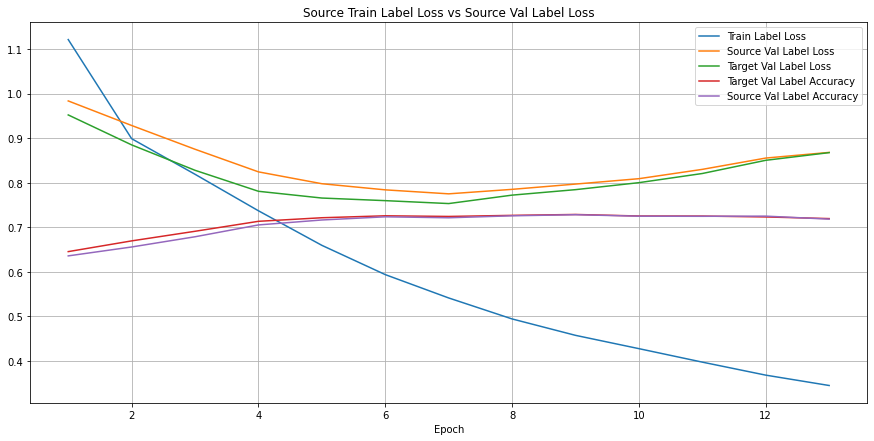

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

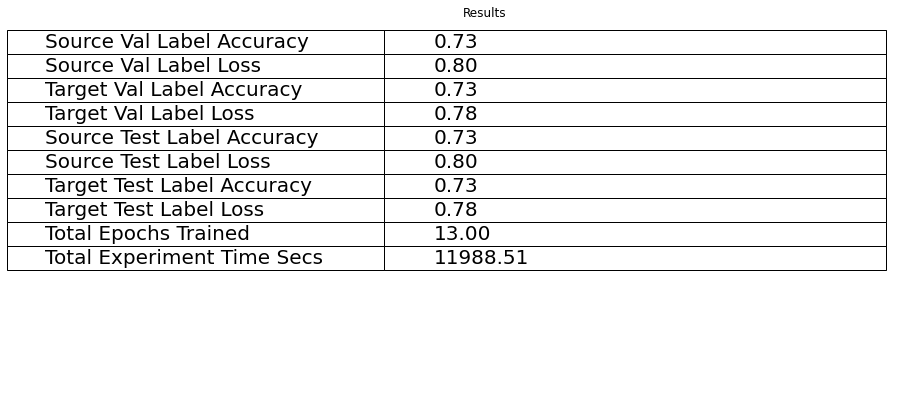

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

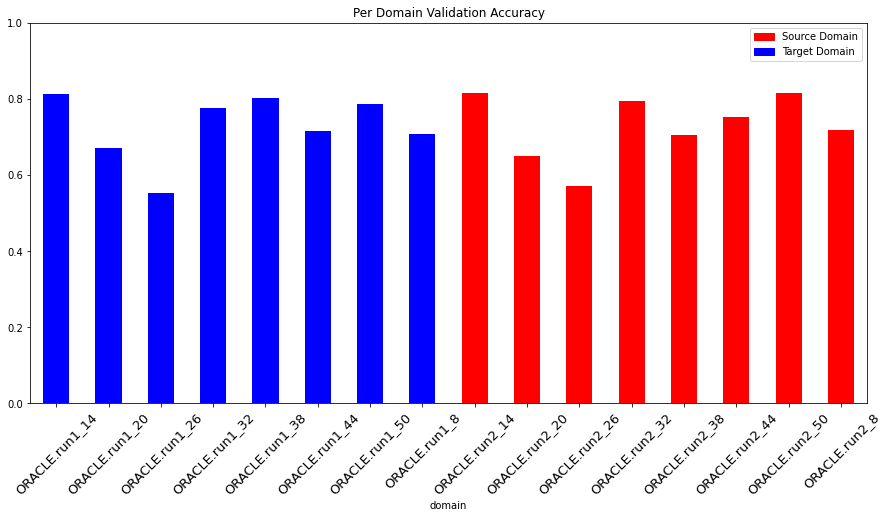

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7262174479166666 Target Test Label Accuracy: 0.7300455729166667
Source Val Label Accuracy: 0.72787109375 Target Val Label Accuracy: 0.7283919270833333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"